In [74]:
import os.path as op
from sklearn.externals.joblib import load
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import f_classif, SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy

In [2]:
base_dir = '/media/lukas/goliath/MVCA/PIOP1'
behav_file = op.join(base_dir, 'PIOP1_behav_2017_with_brainsize.tsv')

In [20]:
mvp = load(op.join(base_dir, 'mvp_vbm.jl'))
mvp.add_y(behav_file, col_name='Gender', index_col=0, nan_strategy='remove')

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin

class ConfoundRegressor(BaseEstimator, TransformerMixin):
    """ Fits a confound onto y and regresses it out X. """

    def __init__(self, confound, fit_idx, stack_intercept=True):
        """ Initializes ArrayPermuter object. """
        
        confound = np.array(confound)
        
        if confound.ndim == 1 or stack_intercept:
            intercept = np.ones(confound.shape[0])
            confound = np.column_stack((intercept, confound))
            
        self.confound = confound
        self.fit_idx = fit_idx
        self.weights_ = None
        
    def fit(self, X, y=None):
        
        confound = self.confound[self.fit_idx]
        weights = np.zeros((X.shape[1], confound.shape[1]))
        
        for i in range(X.shape[1]):
            b, _, _, _ = np.linalg.lstsq(confound, X[:, i])
            weights[i, :] = b
        
        self.weights_ = weights
        
        return self

    def transform(self, X):
        """ Regresses out confound from X.
        
        Parameters
        ----------
        X : ndarray
            Numeric (float) array of shape = [n_samples, n_features]
        Returns
        -------
        X_new : ndarray
            ndarray with confound-regressed features
        """
        
        if X.shape[0] == len(self.fit_idx):
            confound = self.confound[self.fit_idx]
        else:
            tmp_idx = np.ones(self.confound.shape[0], dtype=bool)
            tmp_idx[self.fit_idx] = False
            confound = self.confound[tmp_idx]
        
        for i in range(X.shape[1]):
            X[:, i] -= np.squeeze(confound.dot(self.weights_[i, :]))

        return X

In [21]:
df = pd.read_csv(behav_file, index_col=0, sep='\t')
confound = df.loc[mvp.common_subjects]['brain_size']

In [102]:
n_folds = 20

## Scenario 1: no confound regression

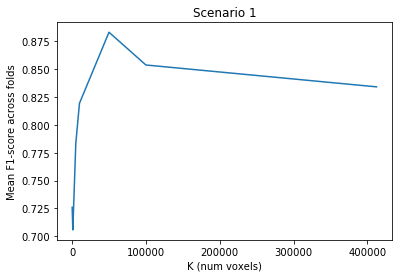

In [103]:
K_vals = [100, 1000, 5000, 10000, 50000, 100000, mvp.X.shape[1]]
f1_scores_sce1 = []
for K in K_vals:

    pipeline = Pipeline([('ufs', SelectKBest(f_classif, k=K)),
                     ('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])

    f1 = cross_val_score(pipeline, mvp.X, mvp.y, cv=n_folds, scoring='f1_macro', n_jobs=8).mean()
    f1_scores_sce1.append(f1)

plt.plot(K_vals, f1_scores_sce1)
plt.title('Scenario 1')
plt.xlabel('K (num voxels)')
plt.ylabel('Mean F1-score across folds')
plt.show()

## Scenario 2: confound regression on entire dataset

In [104]:
mvp_sce2 = deepcopy(mvp)
con_reg = ConfoundRegressor(confound=confound, fit_idx=range(mvp.X.shape[0]))
X_reg = con_reg.fit(mvp_sce2.X, mvp_sce2.y).transform(mvp_sce2.X)
mvp_sce2.X = X_reg

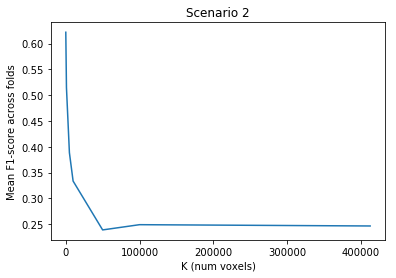

In [105]:
f1_scores_sce2 = []
for K in K_vals:
    pipeline = Pipeline([('ufs', SelectKBest(f_classif, k=K)),
                     ('scaler', StandardScaler()),
                     ('clf', SVC(kernel='linear'))])
    f1 = cross_val_score(pipeline, mvp_sce2.X, mvp_sce2.y, cv=n_folds, scoring='f1_macro', n_jobs=8).mean()
    f1_scores_sce2.append(f1)

plt.plot(K_vals, f1_scores_sce2)
plt.title('Scenario 2')
plt.xlabel('K (num voxels)')
plt.ylabel('Mean F1-score across folds')
plt.show()

## Scenario 3: confound regression on train and cv to test

In [106]:
from tqdm import tqdm
def _parallelize(X, y, K):
    skf = StratifiedKFold(n_splits=n_folds)
    f1s = []
    for train, test in tqdm(skf.split(mvp.X, mvp.y)):
        pipeline = Pipeline([('conreg', ConfoundRegressor(confound=confound,
                                                          fit_idx=train)),
                             ('ufs', SelectKBest(f_classif, k=K)),
                             ('scaler', StandardScaler()),
                             ('clf', SVC(kernel='linear'))])
        pipeline.fit(mvp.X[train], mvp.y[train])
        pred = pipeline.predict(mvp.X[test])
        f1s.append(f1_score(mvp.y[test], pred))
        
    return np.mean(f1s)

In [107]:
from joblib import Parallel, delayed

f1_scores_sce3 = Parallel(n_jobs=10)(delayed(_parallelize)(mvp.X,
                                                           mvp.y,
                                                           k) for k in K_vals)    

20it [13:35, 41.30s/it]
20it [13:37, 39.88s/it]
20it [13:45, 41.42s/it]
20it [13:56, 39.97s/it]
20it [14:25, 41.10s/it]
20it [14:48, 42.12s/it]
20it [18:56, 53.13s/it]


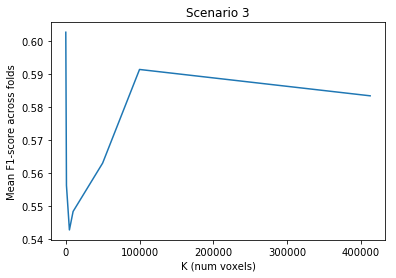

In [108]:
plt.plot(K_vals, f1_scores_sce3)
plt.title('Scenario 3')
plt.xlabel('K (num voxels)')
plt.ylabel('Mean F1-score across folds')
plt.show()

## Scenario 4: confound regression on train and test separately

In [109]:
from tqdm import tqdm
def _parallelize2(X, y, K):
    skf = StratifiedKFold(n_splits=n_folds)
    f1s = []
    
    pipeline = Pipeline([('ufs', SelectKBest(f_classif, k=K)),
                         ('scaler', StandardScaler()),
                         ('clf', SVC(kernel='linear'))])
    f1s = []
    for train, test in tqdm(skf.split(mvp.X, mvp.y)):
        pipeline.fit(mvp.X[train], mvp.y[train])
        pred = pipeline.predict(mvp.X[test])
        f1s.append(f1_score(mvp.y[test], pred))
        
        cr_train = ConfoundRegressor(confound=confound, fit_idx=train)
        train_X, train_y = mvp.X[train], mvp.y[train]
        train_X = cr_train.fit(train_X, train_y).transform(train_X)
        pipeline.fit(train_X, train_y)
    
        cr_test = ConfoundRegressor(confound=confound, fit_idx=test)
        test_X, test_y = mvp.X[test], mvp.y[test]
        test_X = cr_test.fit(test_X, test_y).transform(test_X)
        pred = pipeline.predict(test_X)
        f1s.append(f1_score(test_y, pred))

    return np.mean(f1s)

20it [24:20, 72.41s/it]]
20it [24:20, 73.08s/it]
20it [24:29, 73.21s/it]
20it [24:32, 73.20s/it]
20it [25:16, 72.89s/it]
20it [26:35, 75.08s/it]]
20it [35:06, 97.92s/it] 


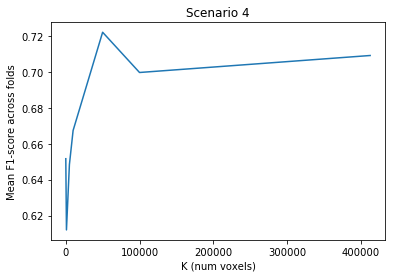

In [110]:
f1_scores_sce4 = Parallel(n_jobs=10)(delayed(_parallelize2)(mvp.X,
                                                           mvp.y,
                                                           k) for k in K_vals)   
plt.plot(K_vals, f1_scores_sce4)
plt.title('Scenario 4')
plt.xlabel('K (num voxels)')
plt.ylabel('Mean F1-score across folds')
plt.show()

## Scenario 5: inverse probability weighting

In [111]:
from sklearn.linear_model import LogisticRegression

skf = StratifiedKFold(n_splits=n_folds)
f1_scores = []
    
logreg = LogisticRegression()

f1_scores_sce5 = []
for K in K_vals:
    print('K = %i' % K)
    pipeline = Pipeline([('ufs', SelectKBest(f_classif, k=K)),
                         ('scaler', StandardScaler()),
                         ('clf', SVC(kernel='linear'))])
    f1s = []
    for train, test in skf.split(mvp.X, mvp.y):
    
        proba = logreg.fit(confound[train][:, np.newaxis],
                           mvp.y[train][:, np.newaxis]).predict_proba(confound[train][:, np.newaxis])
    
        ipw = 1.0/proba[:, 1]
        pipeline.fit(mvp.X[train], mvp.y[train], clf__sample_weight=ipw)
        pred = pipeline.predict(mvp.X[test])
        f1s.append(f1_score(mvp.y[test], pred))
    print(np.mean(f1s))
    f1_scores_sce5.append(np.mean(f1s))
    
print(np.mean(f1_scores_sce5))

K = 100
0.674443611944
K = 1000
0.676012043512
K = 5000
0.74632034632
K = 10000
0.791861471861
K = 50000
0.866565656566
K = 100000
0.834873737374
K = 412473
0.809787157287
0.771409146409
